# Problem description

You are to predict whether a company will go bankrupt in the following year, based on financial attributes of the company.

Perhaps you are contemplating lending money to a company, and need to know whether the company
is in near-term danger of not being able to repay.


## Goal

## Learning objectives

- Demonstrate mastery on solving a classification problem and presenting
the entire Recipe for Machine Learning process in a notebook.
- We will make suggestions for ways to approach the problem
    - But there will be little explicit direction for this task.
- It is meant to be analogous to a pre-interview task that a potential employer might assign
to verify your skill

# Import modules

In [1]:
## Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sklearn

import os
import math

%matplotlib inline


# API for students

In [2]:
## Load the bankruptcy_helper module

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Reload all modules imported with %aimport
%load_ext autoreload
%autoreload 1

# Import bankruptcy_helper module
import bankruptcy_helper
%aimport bankruptcy_helper

helper = bankruptcy_helper.Helper()

# Get the data

The first step in our Recipe is Get the Data.

- Each example is a row of data corresponding to a single company
- There are 64 attributes, described in the section below
- The column `Bankrupt` is 1 if the company subsequently went bankrupt; 0 if it did not go bankrupt
- The column `Id` is a Company Identifier

In [3]:
# Data directory
DATA_DIR = "./Data"

if not os.path.isdir(DATA_DIR):
    DATA_DIR = "../resource/asnlib/publicdata/bankruptcy/data"

data_file = "5th_yr.csv"
data = pd.read_csv( os.path.join(DATA_DIR, "train", data_file) )

target_attr = "Bankrupt"

n_samples, n_attrs = data.shape
print("Date shape: ", data.shape)

Date shape:  (4818, 66)


## Have a look at the data

We will not go through all steps in the Recipe, nor in depth.

But here's a peek

In [4]:
data.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X57,X58,X59,X60,X61,X62,X63,X64,Bankrupt,Id
0,0.025417,0.41769,0.0568,1.1605,-126.39,0.41355,0.025417,1.2395,1.16500,0.51773,...,0.049094,0.85835,0.12322,5.6167,7.4042,164.310,2.2214,1.334,0,4510
1,-0.023834,0.2101,0.50839,4.2374,22.034,0.058412,-0.027621,3.6579,0.98183,0.76855,...,-0.031011,1.01850,0.069047,5.7996,7.7529,26.446,13.802,6.4782,0,3537
2,0.030515,0.44606,0.19569,1.565,35.766,0.28196,0.039264,0.88456,1.05260,0.39457,...,0.077337,0.95006,0.25266,15.049,2.8179,104.730,3.4852,2.6361,0,3920
3,0.052318,0.056366,0.54562,10.68,438.2,0.13649,0.058164,10.853,1.02790,0.61173,...,0.085524,0.97282,0,6.0157,7.4626,48.756,7.4863,1.0602,0,1806
4,0.000992,0.49712,0.12316,1.3036,-71.398,0,0.001007,1.0116,1.29210,0.50288,...,0.001974,0.99925,0.019736,3.4819,8.582,114.580,3.1854,2.742,0,1529


Pretty *unhelpful* !

What are these mysteriously named features ?

## Description of attributes

This may still be somewhat unhelpful for those of you not used to reading Financial Statements.

But that's partially the point of the exercise
- You can *still* perform Machine Learning *even if* you are not an expert in the problem domain
    - That's what makes this a good interview exercise: you can demonstrate your thought process even if you don't know the exact meaning of the terms
- Of course: becoming an expert in the domain *will improve* your ability to create better models
    - Feature engineering is easier if you understand the features, their inter-relationships, and the relationship to the target

Let's get a feel for the data
- What is the type of each attribute ?


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4818 entries, 0 to 4817
Data columns (total 66 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   X1        4818 non-null   object 
 1   X2        4818 non-null   object 
 2   X3        4818 non-null   object 
 3   X4        4818 non-null   object 
 4   X5        4818 non-null   object 
 5   X6        4818 non-null   object 
 6   X7        4818 non-null   object 
 7   X8        4818 non-null   object 
 8   X9        4818 non-null   float64
 9   X10       4818 non-null   object 
 10  X11       4818 non-null   object 
 11  X12       4818 non-null   object 
 12  X13       4818 non-null   float64
 13  X14       4818 non-null   object 
 14  X15       4818 non-null   object 
 15  X16       4818 non-null   object 
 16  X17       4818 non-null   object 
 17  X18       4818 non-null   object 
 18  X19       4818 non-null   float64
 19  X20       4818 non-null   float64
 20  X21       4818 non-null   obje

You may be puzzled:
- Most attributes are `object` and *not* numeric (`float64`)
- But looking at the data via `data.head()` certainly gives the impression that all attributes are numeric

Welcome to the world of messy data !  The dataset has represented numbers as strings.
- These little unexpected challenges are common in the real-word
- Data is rarely perfect and clean

So you might want to first convert all attributes to numeric

**Hint**
- Look up the Pandas method `to_numeric`
    - We suggest you use the option `errors='coerce'`
    

# Evaluating your project

We will evaluate your submission on a test dataset that we provide
- It has no labels, so **you** can't use it to evaluate your model, but **we** have the labels
- We will call this evaluation dataset the "holdout" data

Let's get it

In [6]:
holdout_data = pd.read_csv( os.path.join(DATA_DIR, "holdout", '5th_yr.csv') )

print("Data shape: ", holdout_data.shape)


Data shape:  (1092, 65)


We will evaluate your model on the holdout examples using metrics
- Accuracy
- Recall
- Precision

From our lecture: we may have to make a trade-off between Recall and Precision.

Our evaluation of your submission will be partially based on how you made (and described) the trade-off.

You may assume that it is 5 times worse to *fail to identify a company that will go bankrupt*
than it is to fail to identify a company that won't go bankrupt.

# Your model

Time for you to continue the Recipe for Machine Learning on your own.



## Create a test set and put it aside

We want to split the original dataset into train set and test set
- 90% will be train set 
- 10% will be test set

Before we create a test set, we convert all attributes to numeric. 

We try to use the `to_numeric` together with `errors='coerce'` in pandas.

In this method, if the value can not be converted into numeric, it will become NaN.

In [7]:
from sklearn.model_selection import train_test_split
import sklearn
## Shuffle the data first
data = sklearn.utils.shuffle(data, random_state=42)
#since many attributes are not numeric, so firstly we convert all the attributes into numeric
data = data.apply(lambda x: pd.to_numeric(x, errors = 'coerce'))
X = data.iloc[:, 0:64]
y = data.iloc[:, -2]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 42)
print("X_train shape: ", X_train.shape)
print("X_test shape: ", X_test.shape)
print("y_train shape: ", y_train.shape)
print("y_test shape: ", y_test.shape)

X_train shape:  (4336, 64)
X_test shape:  (482, 64)
y_train shape:  (4336,)
y_test shape:  (482,)


In [8]:
X

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X55,X56,X57,X58,X59,X60,X61,X62,X63,X64
4340,0.001173,0.672030,0.142270,1.2156,-49.408,0.016824,0.001271,0.48075,1.00740,0.32308,...,19985.00,0.007312,0.003629,0.99269,0.037272,12.3020,4.04420,140.440,2.5991,8.67450
1221,0.139630,0.250810,0.258480,2.2523,31.714,0.000000,0.182390,2.98710,1.54600,0.74919,...,2443.90,0.124670,0.186370,0.88279,0.044616,11.2790,5.10960,48.732,7.4899,2.88910
2083,0.147600,0.097863,0.469870,6.4957,59.981,0.003564,0.181560,9.21840,1.44620,0.90214,...,19041.00,0.123660,0.163620,0.87543,0.000000,5.5314,6.87320,21.578,16.9160,3.25260
1044,0.032618,0.743750,0.052153,1.1584,-49.698,0.111270,0.044782,0.33163,1.05450,0.24665,...,4087.90,0.051681,0.132240,0.94832,1.680600,6.5521,33.06500,59.524,6.1319,3.26330
2555,0.022155,0.548750,0.540930,2.8668,14.402,0.000000,0.022155,0.82231,0.61232,0.45125,...,4408.80,0.066985,0.049097,0.96466,0.558330,1.1969,2.58290,172.720,2.1132,3.61640
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4426,0.169670,0.330950,0.134730,3.3294,36.983,0.442650,0.169670,2.02160,1.22160,0.66905,...,772.71,0.300630,0.253600,0.72390,0.375260,28.6890,24.46700,17.281,21.1210,1.51300
466,0.000000,0.000000,0.449150,NaN,6792.300,0.000000,0.000000,NaN,1.82580,0.54961,...,8128.10,0.452290,0.000000,0.54771,0.000000,2.2926,0.11672,0.000,NaN,0.89252
3092,-0.016300,0.845470,0.173100,1.7735,2.052,-0.010840,-0.016860,0.16959,1.04490,0.14338,...,7380.30,0.042962,-0.113680,0.95704,4.335800,7.3470,6.56170,67.638,5.3964,2.00250
3772,0.580460,0.515020,0.134920,1.2636,67.498,0.000000,0.580460,0.94167,3.57720,0.48498,...,253.67,0.775710,1.196900,0.22849,0.000000,17.3420,8.61690,52.230,6.9884,10.12800


## Exploratory Data Analysis

In this step, we try to gain some insights from visualizing our data.

Firstly, let's take a look at our data description again.

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
X_train.describe()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X55,X56,X57,X58,X59,X60,X61,X62,X63,X64
count,4334.000000,4334.000000,4334.000000,4322.000000,4.327000e+03,4334.000000,4334.000000,4323.000000,4336.000000,4334.000000,...,4.336000e+03,4336.000000,4334.000000,4336.000000,4334.000000,4.140000e+03,4325.000000,4336.000000,4322.000000,4259.000000
mean,-0.066463,0.534571,0.190742,5.232440,1.915000e+01,-0.078235,-0.053559,6.059490,1.579078,0.508771,...,1.080641e+04,0.055017,0.002823,0.960357,0.280985,1.221799e+03,11.212115,177.071746,9.534976,37.514776
std,7.070258,1.256668,1.341357,105.696196,2.513463e+04,8.198406,7.070873,115.412263,1.342739,4.259593,...,8.615752e+04,0.792608,7.618977,0.963686,6.644839,7.489282e+04,45.950413,2369.890843,119.312530,587.109864
min,-463.890000,0.000000,-72.067000,0.000000,-1.076400e+06,-463.890000,-463.890000,-3.735100,0.000191,-71.444000,...,-1.118500e+06,-46.788000,-468.670000,-0.085920,-184.980000,-1.244000e+01,-0.092493,0.000000,0.000000,-3.726500
25%,0.004419,0.253770,0.048167,1.107925,-4.272450e+01,0.000000,0.006428,0.482905,1.016400,0.320368,...,1.088525e+02,0.011321,0.015622,0.876918,0.000000,5.355075e+00,4.220800,44.781750,3.078300,2.130500
50%,0.046647,0.450660,0.219530,1.649250,8.066700e-01,0.000000,0.057010,1.152400,1.143950,0.523170,...,1.877950e+03,0.053489,0.109020,0.950980,0.006320,8.998550e+00,6.181300,73.778500,4.931500,4.077200
75%,0.117233,0.661567,0.421368,2.941425,5.013450e+01,0.111240,0.136300,2.802550,1.816125,0.722352,...,7.757700e+03,0.123507,0.240523,0.990655,0.204370,1.717825e+01,9.294700,118.290000,8.095575,9.214800
max,2.352300,72.416000,28.336000,6845.800000,1.250100e+06,203.150000,2.352300,6868.500000,37.807000,266.860000,...,4.212200e+06,1.000000,87.981000,47.788000,308.150000,4.818700e+06,1308.500000,127450.000000,7641.300000,28999.000000


In [10]:
y_train.describe()

count    4336.000000
mean        0.061808
std         0.240834
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: Bankrupt, dtype: float64

- Our data contain some null values because we convert data into numeric data and some of non-numeric data become NaN.
- Our data contain some outliers. In some features, max value and min value are too far away from the median.
- From the description of our labels, we can see that maybe our labels are imbalanced.
- We will explore more in the following steps.

We try to check the number of our labels.

<AxesSubplot:title={'center':'Label distribution'}>

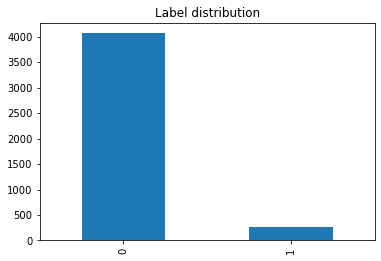

In [11]:
counts = y_train.value_counts()
counts.plot(kind="bar", title="Label distribution")

In [12]:
print('{:.2f}% labels in train set are not bankrupt'.format(counts[0]/counts.sum()*100))
print('{:.2f}% labels in train set are bankrupt'.format(counts[1]/counts.sum()*100))

93.82% labels in train set are not bankrupt
6.18% labels in train set are bankrupt


Our data are imbalanced. Only 6.39% of labels are bankrupt.

We can visualize our features using box plot which we will help us find outliers.

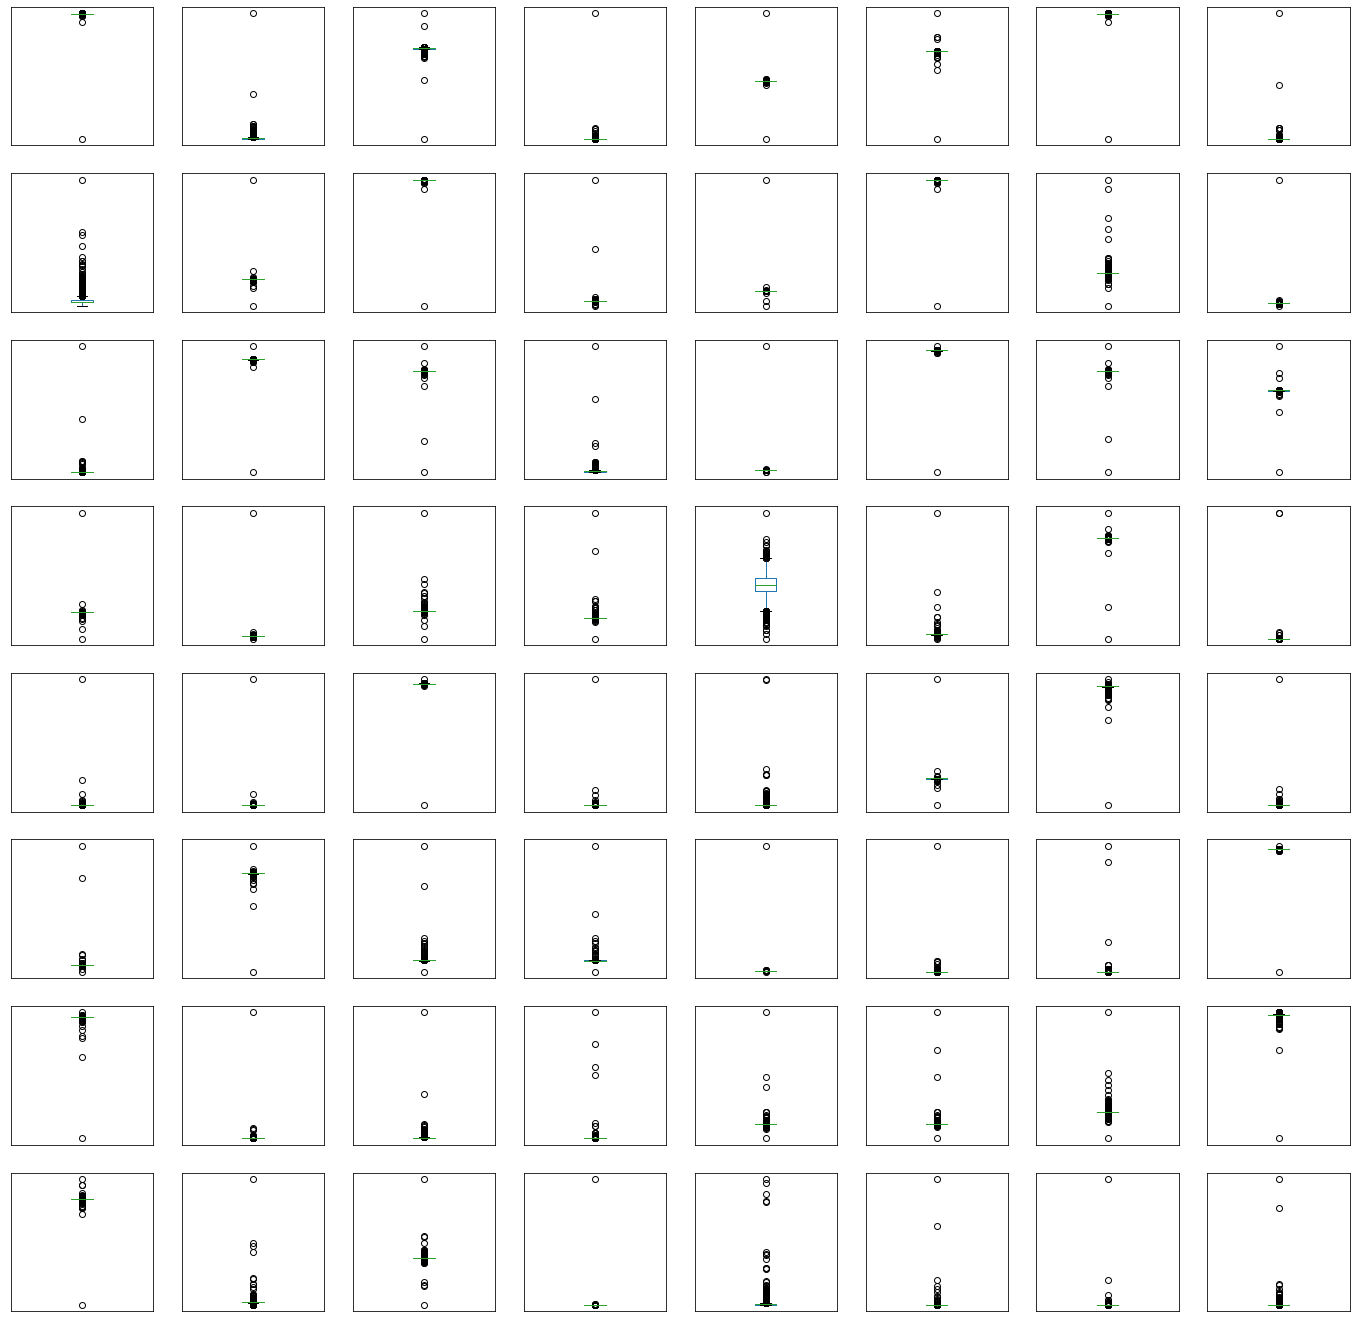

In [13]:
#Here we hide the xticks and yticks, since their scales are different.
_ = X_train.iloc[:,:].plot(kind='box',figsize=(24,24), subplots=True, xticks=[], yticks=[], layout=(8,8))

We also want to boxplot our attributes grouped by targets and see the patterns.

In [14]:
X_train_p = X_train.copy()
X_train_p['bankrupt'] = y_train

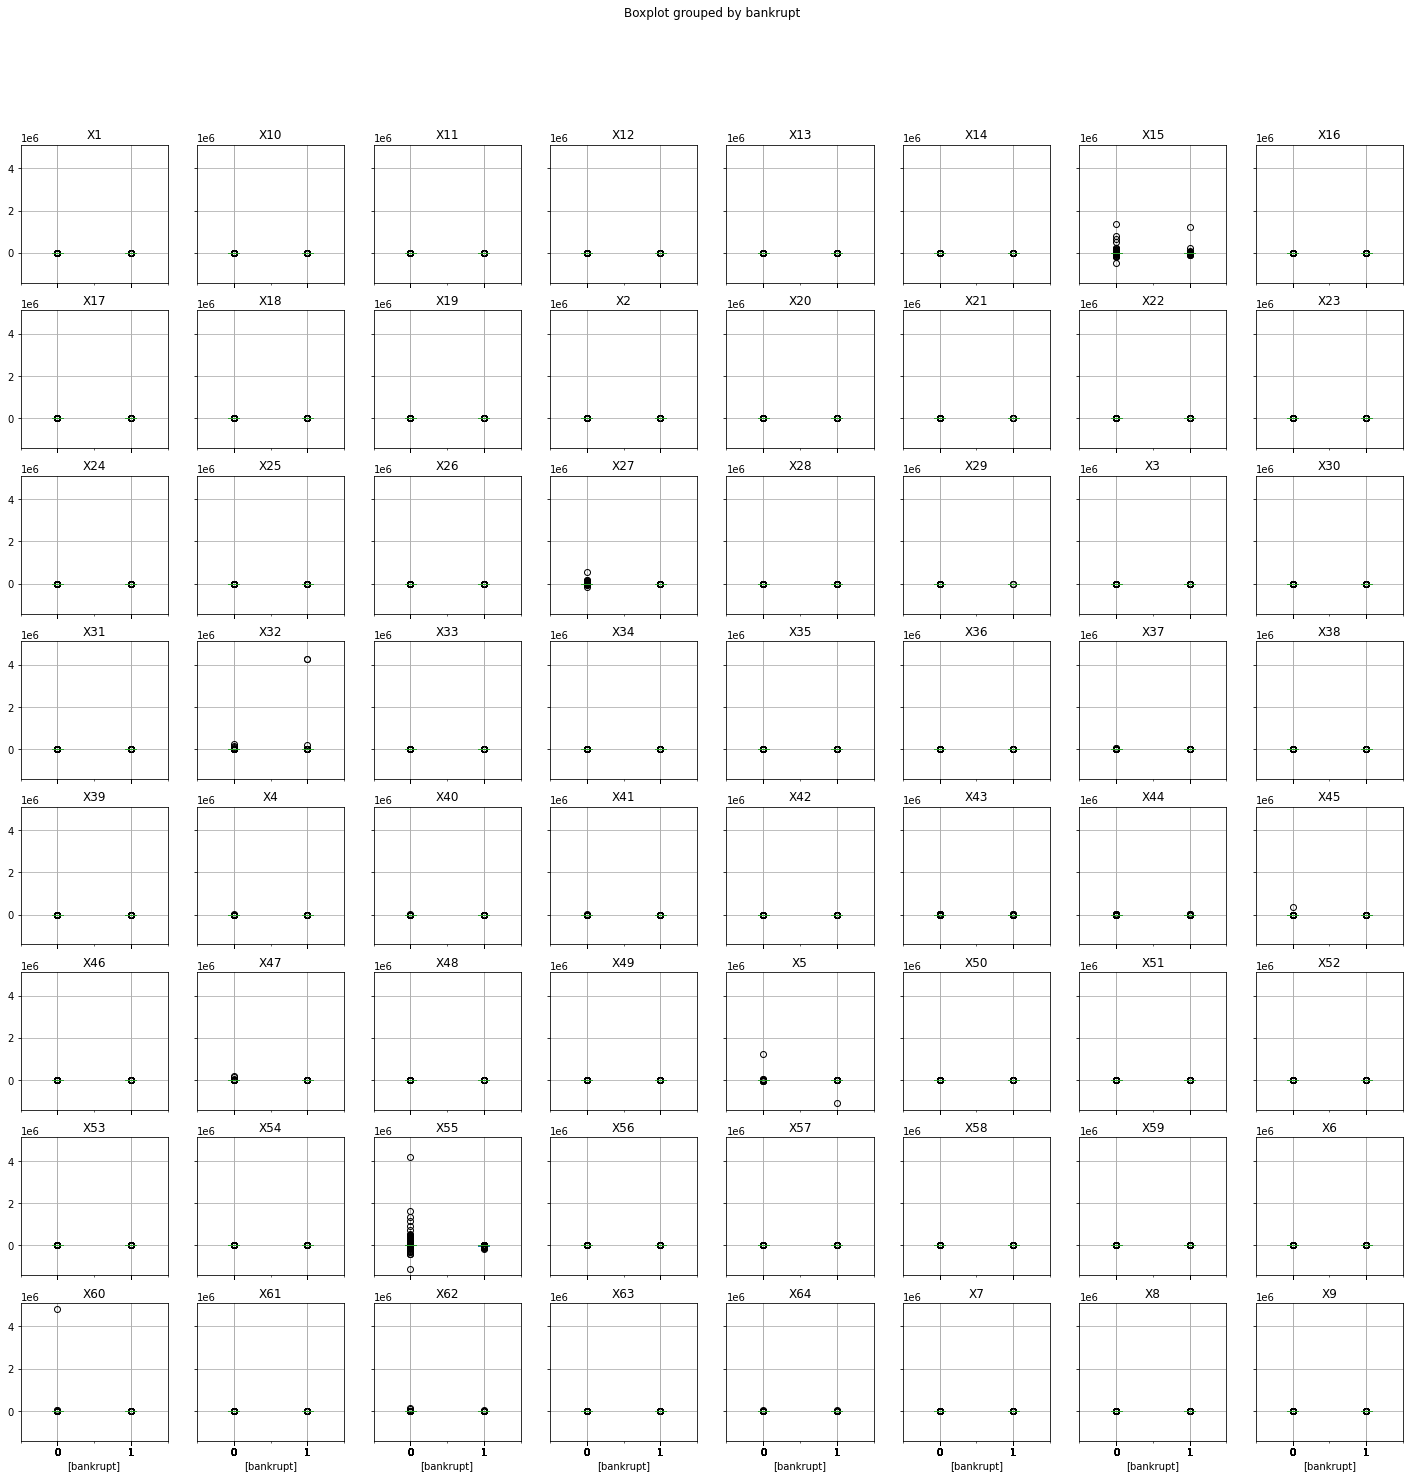

In [15]:
_ = X_train_p.boxplot(by='bankrupt', figsize=(24,24), layout=(8,8))

We can also visualize our attributes using line.

We can see that most of the attributes have similar patterns.

Most of the data points are within a range and there are few extreme outliers.

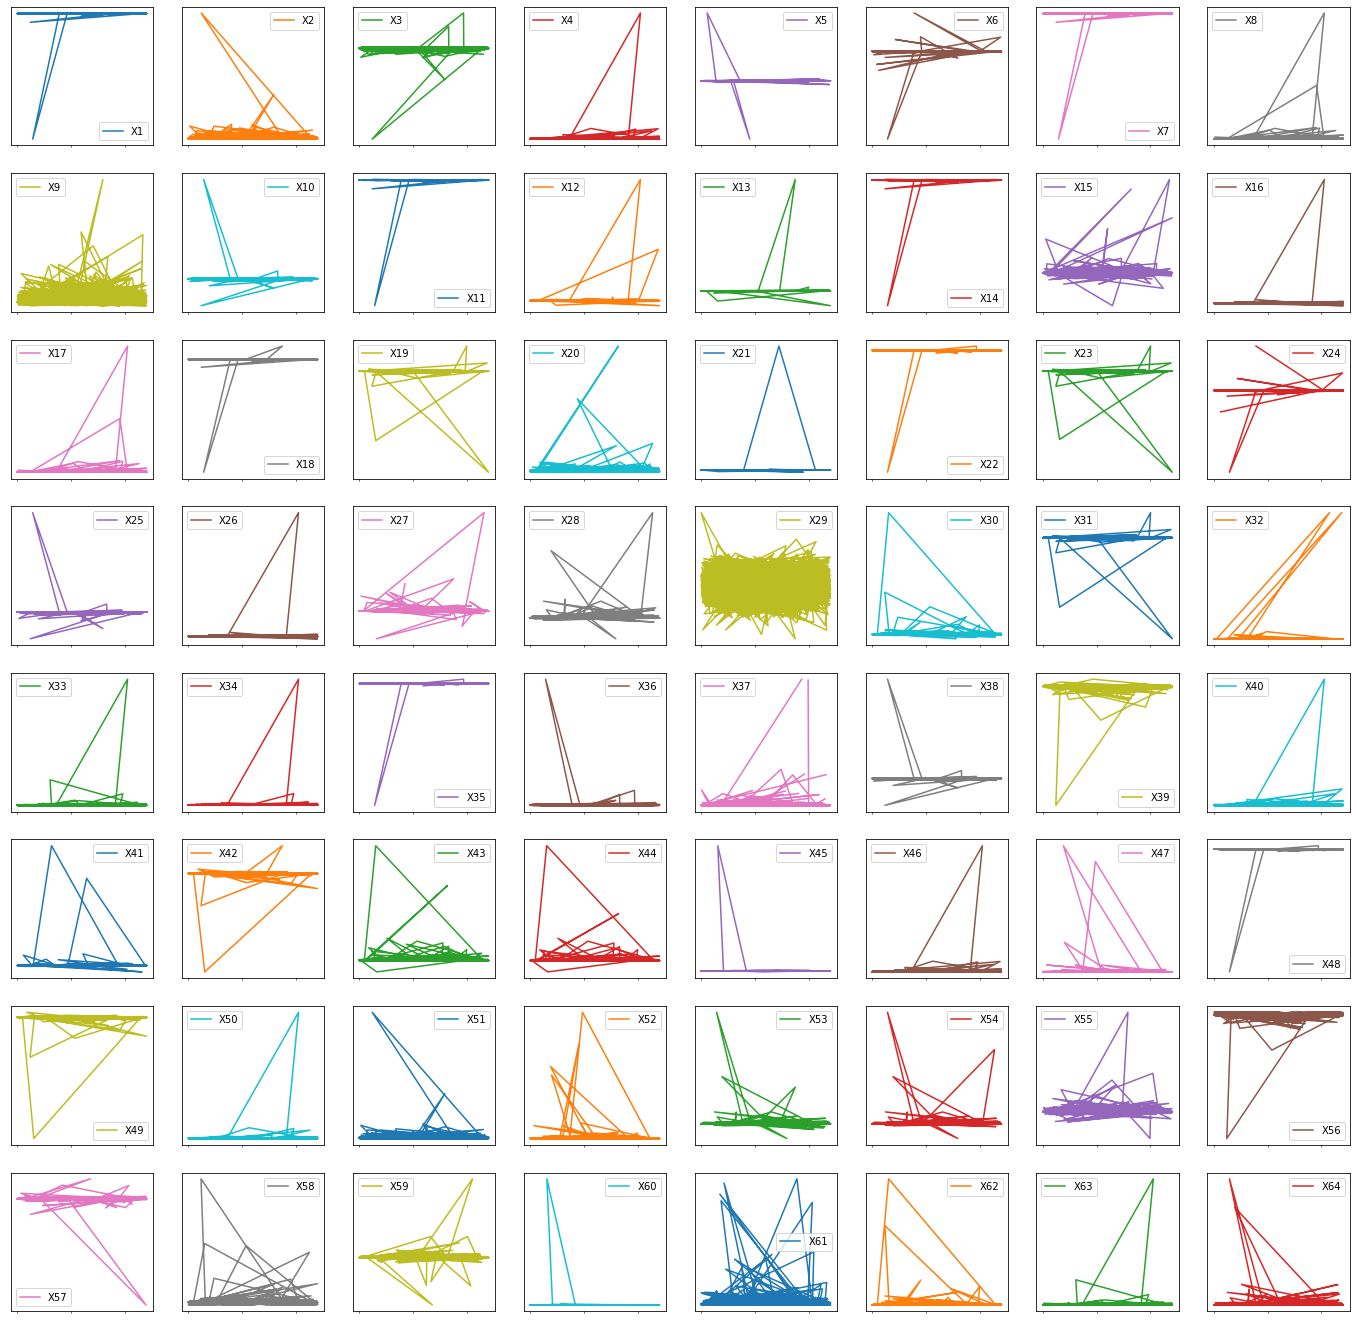

In [16]:
_ = X_train.iloc[:,:].plot(kind='line',figsize=(24,24), subplots=True, xticks=[], yticks=[], layout=(8,8))

From our exploratory data analysis, we at least find the following conclusions about our data:
- Our data contain null values.
- Our data are imbalanced.
- Feature values are different in scale. 
- Significant outliers exist in most of our features.

Those conclusions can guide our next step: prepare the data.

# Prepare the data
In this step, we will try to clean out data, do some transformations and scale our data.

We will explain our approaches first and build a pipeline to avoid data leakage later.

## Prepare the data: Cleaning

- Our initial data exploration revealed some attributes with null values
- Since our attributes are all numeric, we will use median value to fill the null values
- We use median value here because the mean value is affected by some outliers in data

In [17]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='median')
X_train_ = X_train.copy()
X_train_[X_train_.columns] = imputer.fit_transform(X_train[X_train_.columns])

In [18]:
X_train_.describe()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X55,X56,X57,X58,X59,X60,X61,X62,X63,X64
count,4336.000000,4336.000000,4336.000000,4336.000000,4.336000e+03,4336.000000,4336.000000,4336.000000,4336.000000,4336.000000,...,4.336000e+03,4336.000000,4336.000000,4336.000000,4336.000000,4.336000e+03,4336.000000,4336.000000,4336.000000,4336.000000
mean,-0.066411,0.534532,0.190755,5.220871,1.911192e+01,-0.078199,-0.053508,6.044778,1.579078,0.508777,...,1.080641e+04,0.055017,0.002872,0.960357,0.280858,1.166977e+03,11.199352,177.071746,9.520112,36.920982
std,7.068627,1.256379,1.341048,105.525579,2.510852e+04,8.196515,7.069242,115.239393,1.342739,4.258611,...,8.615752e+04,0.792608,7.617219,0.963686,6.643308,7.318060e+04,45.892774,2369.890843,119.119999,581.889024
min,-463.890000,0.000000,-72.067000,0.000000,-1.076400e+06,-463.890000,-463.890000,-3.735100,0.000191,-71.444000,...,-1.118500e+06,-46.788000,-468.670000,-0.085920,-184.980000,-1.244000e+01,-0.092493,0.000000,0.000000,-3.726500
25%,0.004429,0.253770,0.048341,1.111250,-4.259900e+01,0.000000,0.006458,0.484027,1.016400,0.320402,...,1.088525e+02,0.011321,0.015687,0.876918,0.000000,5.486600e+00,4.225575,44.781750,3.084525,2.162650
50%,0.046647,0.450660,0.219530,1.649250,8.066700e-01,0.000000,0.057010,1.152400,1.143950,0.523170,...,1.877950e+03,0.053489,0.109020,0.950980,0.006320,8.998550e+00,6.181300,73.778500,4.931500,4.077200
75%,0.117117,0.661362,0.421222,2.937625,5.006300e+01,0.111180,0.136260,2.782575,1.816125,0.722338,...,7.757700e+03,0.123507,0.240487,0.990655,0.204030,1.628375e+01,9.286975,118.290000,8.083050,9.051975
max,2.352300,72.416000,28.336000,6845.800000,1.250100e+06,203.150000,2.352300,6868.500000,37.807000,266.860000,...,4.212200e+06,1.000000,87.981000,47.788000,308.150000,4.818700e+06,1308.500000,127450.000000,7641.300000,28999.000000


After imputing, now we have attributes without null values.

We still have the following problems in our data:

- Our data have outliers 
- Our data are imbalanced 
- Our data has different scales

In the next step, we will transform our data to solve outliers and scale our data.

## Prepare the data: Transformation

In this step, we will mainly focus on dealing with outliers and scaling our data.

There are some outliers in our data. We try to use a method of Box Plot to detect outliers and limit the value

If a value is higher than 10 * IQR above upper quartile(Q3), the value will be considered as outlier. 

If a value is lower than 10 * IQR below lower quartile(Q1), the value will be considered as outlier.

- IQR = Q3 - Q1
- The upper bound = Q3 + 10 * IQR 
- The lower bound = Q1 - 10 * IQR

Let's take a look at the upper bound and lower bound compared with median value 

In [83]:
for i in range(X_train_.shape[1]):
    col = X_train_.iloc[:, i].copy()
    q1 = col.quantile(0.25)
    q3 = col.quantile(0.75)
    IQR = q3 - q1
    upper = q3 + 10*IQR
    lower = q1 - 10*IQR
    n_outliers = len(col[(col > upper) | (col < lower)])
    pct_outliers = n_outliers/len(col)
    print('{}: upper bound: {:.2f} lower bound: {:.2f} percentage of outlier: {:.2f}%'.format(
        X_train_.columns[i], upper, lower, pct_outliers*100))

X1: upper bound: 1.24 lower bound: -1.12 percentage of outlier: 0.46%
X2: upper bound: 4.74 lower bound: -3.82 percentage of outlier: 0.35%
X3: upper bound: 4.15 lower bound: -3.68 percentage of outlier: 0.35%
X4: upper bound: 21.20 lower bound: -17.15 percentage of outlier: 1.29%
X5: upper bound: 976.68 lower bound: -969.22 percentage of outlier: 1.45%
X6: upper bound: 1.22 lower bound: -1.11 percentage of outlier: 2.40%
X7: upper bound: 1.43 lower bound: -1.29 percentage of outlier: 0.39%
X8: upper bound: 25.77 lower bound: -22.50 percentage of outlier: 1.59%
X9: upper bound: 9.81 lower bound: -6.98 percentage of outlier: 0.28%
X10: upper bound: 4.74 lower bound: -3.70 percentage of outlier: 0.42%
X11: upper bound: 1.46 lower bound: -1.29 percentage of outlier: 0.32%
X12: upper bound: 5.80 lower bound: -5.23 percentage of outlier: 1.73%
X13: upper bound: 1.23 lower bound: -1.07 percentage of outlier: 0.88%
X14: upper bound: 1.43 lower bound: -1.29 percentage of outlier: 0.39%
X15: up

We can see that based on our definition of outliers, most of attributes have less than 5% outliers.

Most researchers use 3 * IQR. If we use 3 * IQR, there will be a lot of data being considered as outliers.

We change it a little to 10 * IQR here, since we only want to consider those really extreme values as outliers.

For values that are over the bound, we limit their values as upper bound or lower bound.

This may make sense for financial data of a company because for some financial attributes, the upper and lower bound 

could describe the information of "good" or "bad" performance for that financial attribute.

To implement our method of dealing with outliers, we build a class which can also help us build pipeline and avoid data leakage.

In [86]:
from sklearn.base import BaseEstimator, TransformerMixin

class DealOutlier(BaseEstimator, TransformerMixin):
    def __init__(self, factor=10):
        self.factor = factor
    
    def fit(self, X, y=None):
        X_ = X.copy()
        X_ = np.array(X_)
        self.upper = []
        self.lower = []
        for i in range(X_.shape[1]):
            col = X_[:,i].copy()
            q1 = np.quantile(col, 0.25)
            q3 = np.quantile(col, 0.75)
            IQR = q3 - q1
            upper = q3 + self.factor*IQR
            lower = q1 - self.factor*IQR
            self.upper.append(upper)
            self.lower.append(lower)
        return self
    
    def transform(self, X, y = None):
        X_ = X.copy()
        X_ = np.array(X_)
        for i in range(X_.shape[1]):
            col = X_[:,i]
            up = self.upper[i]
            lo = self.lower[i]
            col[col > up] = up
            col[col < lo] = lo 
        return X_
    
    

In [87]:
outlier = DealOutlier()
X_train_ol = X_train_.copy()
X_train_ol[X_train_ol.columns] = outlier.fit_transform(X_train_ol)

In [88]:
X_train_ol.describe()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X55,X56,X57,X58,X59,X60,X61,X62,X63,X64
count,4336.000000,4336.000000,4336.000000,4336.000000,4336.000000,4336.000000,4336.000000,4336.000000,4336.000000,4336.000000,...,4336.000000,4336.000000,4336.000000,4336.000000,4336.000000,4336.000000,4336.000000,4336.000000,4336.000000,4336.000000
mean,0.053317,0.509392,0.206181,2.776297,3.076985,0.023212,0.065545,2.680463,1.560474,0.472745,...,7067.721675,0.076089,0.123614,0.925682,0.196655,17.225817,8.647071,103.683298,6.974034,10.888612
std,0.175648,0.442947,0.420183,3.402969,179.261029,0.289689,0.192151,4.493299,1.104276,0.457560,...,19426.854456,0.204160,0.490178,0.201735,0.547883,24.875623,9.106007,115.275857,7.484469,18.098600
min,-1.122450,0.000000,-3.680474,0.000000,-969.219000,-1.111800,-1.291562,-3.735100,0.000191,-3.698948,...,-76379.622500,-1.110541,-2.232315,-0.085920,-2.040300,-12.440000,-0.092493,0.000000,0.000000,-3.726500
25%,0.004429,0.253770,0.048341,1.111250,-42.599000,0.000000,0.006458,0.484027,1.016400,0.320402,...,108.852500,0.011321,0.015687,0.876918,0.000000,5.486600,4.225575,44.781750,3.084525,2.162650
50%,0.046647,0.450660,0.219530,1.649250,0.806670,0.000000,0.057010,1.152400,1.143950,0.523170,...,1877.950000,0.053489,0.109020,0.950980,0.006320,8.998550,6.181300,73.778500,4.931500,4.077200
75%,0.117117,0.661362,0.421222,2.937625,50.063000,0.111180,0.136260,2.782575,1.816125,0.722338,...,7757.700000,0.123507,0.240487,0.990655,0.204030,16.283750,9.286975,118.290000,8.083050,9.051975
max,1.243997,4.737287,4.150037,21.201375,976.683000,1.222980,1.434280,25.768050,9.813375,4.741688,...,84246.175000,1.000000,2.488490,2.128030,2.244330,124.255250,59.900975,853.372500,58.068300,77.945225


## Parepare the data: Scaling

Here we try to scale our data with standardizing.

We will remove mean and scale with standard deviation.

We can use `StandardScaler` to implement it.

In [89]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_ol_sc = X_train_ol.copy()
X_train_ol_sc[X_train_ol_sc.columns] = scaler.fit_transform(X_train_ol_sc)

In [90]:
X_train_ol_sc.describe()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X55,X56,X57,X58,X59,X60,X61,X62,X63,X64
count,4.336000e+03,4.336000e+03,4.336000e+03,4.336000e+03,4.336000e+03,4.336000e+03,4.336000e+03,4.336000e+03,4.336000e+03,4.336000e+03,...,4.336000e+03,4.336000e+03,4.336000e+03,4.336000e+03,4.336000e+03,4.336000e+03,4.336000e+03,4.336000e+03,4.336000e+03,4.336000e+03
mean,-1.715520e-17,-3.704755e-16,1.106126e-17,-9.375636e-17,4.141572e-17,-1.713472e-16,9.818151e-17,-1.785933e-17,1.443341e-16,9.509613e-17,...,3.950817e-17,2.892059e-17,-1.187101e-17,-3.060027e-16,1.156824e-16,-1.021374e-16,-1.262187e-16,-8.626249e-17,-5.833728e-17,-8.820845e-18
std,1.000115e+00,1.000115e+00,1.000115e+00,1.000115e+00,1.000115e+00,1.000115e+00,1.000115e+00,1.000115e+00,1.000115e+00,1.000115e+00,...,1.000115e+00,1.000115e+00,1.000115e+00,1.000115e+00,1.000115e+00,1.000115e+00,1.000115e+00,1.000115e+00,1.000115e+00,1.000115e+00
min,-6.694677e+00,-1.150141e+00,-9.250981e+00,-8.159396e-01,-5.424537e+00,-3.918487e+00,-7.063523e+00,-1.427971e+00,-1.413109e+00,-9.118316e+00,...,-4.295959e+00,-5.812940e+00,-4.806824e+00,-5.015086e+00,-4.083376e+00,-1.192703e+00,-9.598688e-01,-8.995401e-01,-9.319083e-01,-8.076204e-01
25%,-2.783617e-01,-5.771615e-01,-3.756885e-01,-4.893489e-01,-2.548309e-01,-8.013771e-02,-3.075389e-01,-4.888810e-01,-4.927539e-01,-3.329847e-01,...,-3.582501e-01,-3.172782e-01,-2.202032e-01,-2.417545e-01,-3.589771e-01,-4.719709e-01,-4.856141e-01,-5.110206e-01,-5.197373e-01,-4.821903e-01
50%,-3.797759e-02,-1.326098e-01,3.177407e-02,-3.312335e-01,-1.266631e-02,-8.013771e-02,-4.442652e-02,-3.401151e-01,-3.772350e-01,1.102162e-01,...,-2.671750e-01,-1.107088e-01,-2.977553e-02,1.254153e-01,-3.474395e-01,-3.307743e-01,-2.708163e-01,-2.594494e-01,-2.729344e-01,-3.763936e-01
75%,3.632699e-01,3.431287e-01,5.118408e-01,4.741336e-02,2.621397e-01,3.036972e-01,3.680595e-01,2.272808e-02,2.315371e-01,5.455485e-01,...,3.552083e-02,2.322880e-01,2.384588e-01,3.221067e-01,1.346282e-02,-3.787547e-02,7.028085e-02,1.267255e-01,1.481928e-01,-1.014912e-01
max,6.779585e+00,9.546031e+00,9.387133e+00,5.415036e+00,5.431846e+00,4.142047e+00,7.124043e+00,5.138819e+00,7.474447e+00,9.330880e+00,...,3.973230e+00,4.525957e+00,4.825079e+00,5.960719e+00,3.737862e+00,4.303079e+00,5.629231e+00,6.504186e+00,6.827493e+00,3.705499e+00


Take a look at our data 

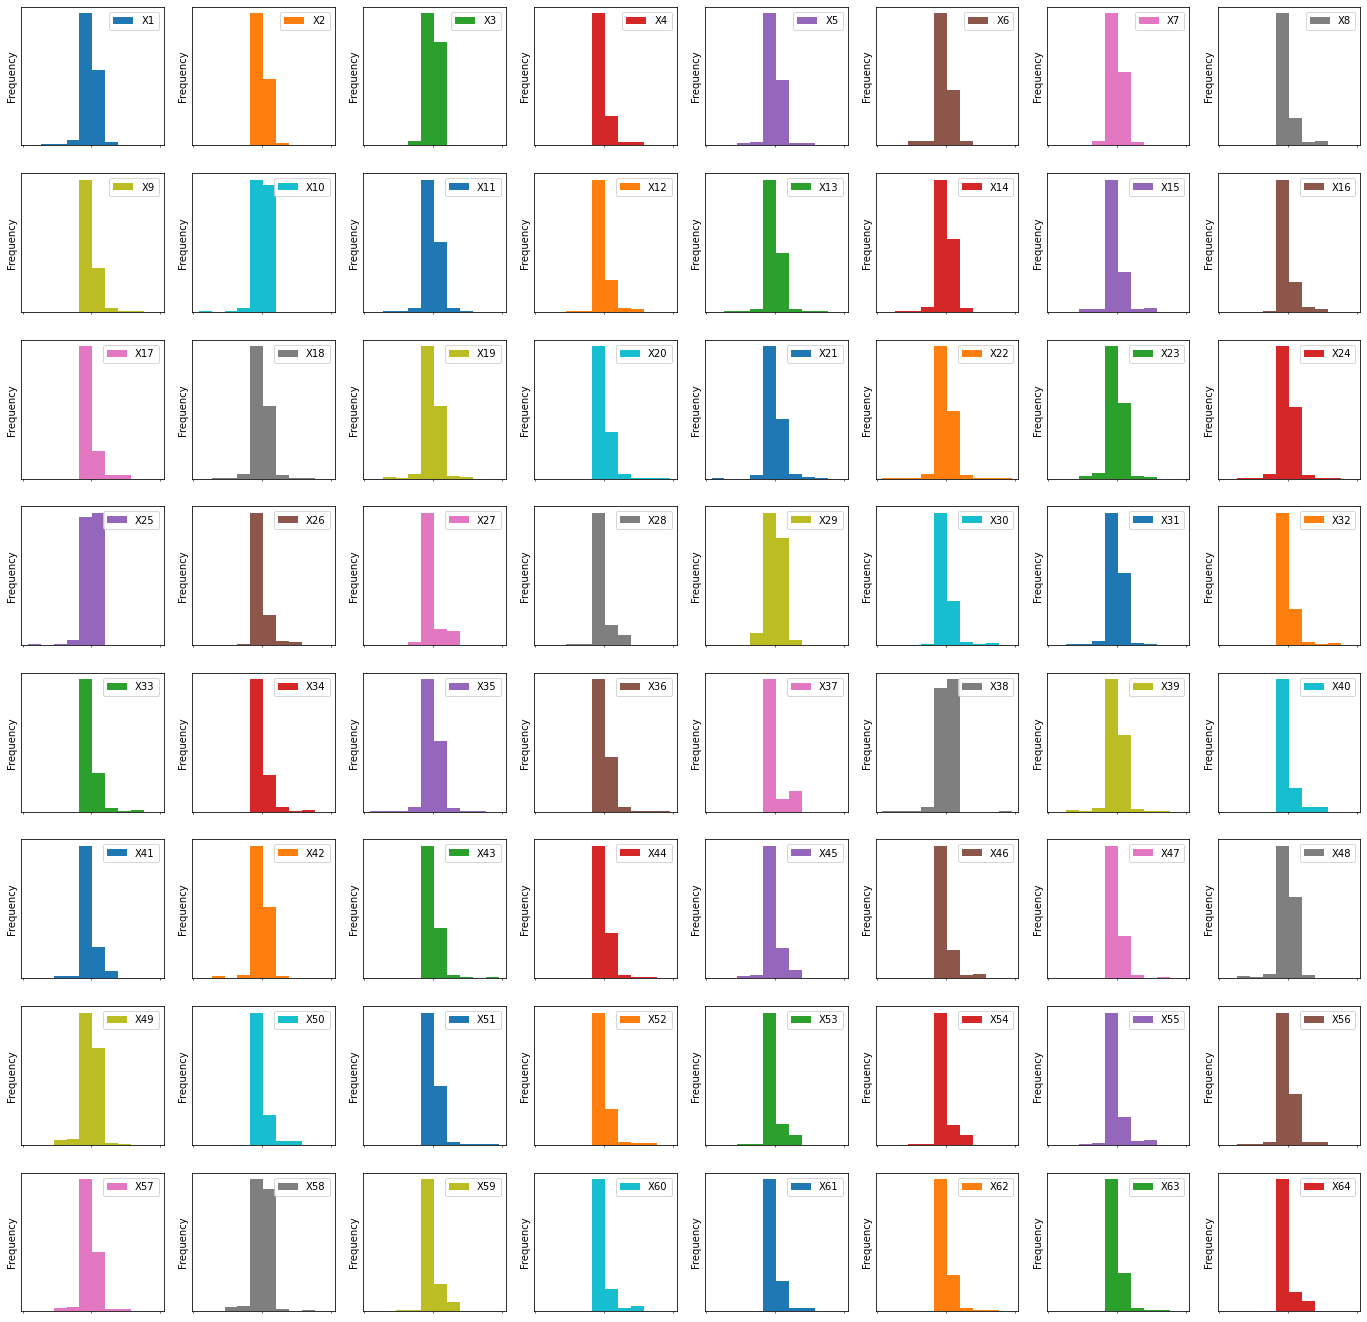

In [91]:
_ = X_train_ol_sc.plot(kind='hist',figsize=(24,24), subplots=True, xticks=[], yticks=[], layout=(8,8))

## Prepare the data: Dimension Reduction

After scaling, our attributes are centered.

We have 64 features right now which are a lot. We want to have a lower dimensions of features.

We will use PCA and choose number of dimensions with 95% explained variance. 

In [92]:
from sklearn.decomposition import PCA
pca = PCA(n_components=0.95)
X_train_ol_sc_pca = X_train_ol_sc.copy()
X_train_ol_sc_pca = pca.fit_transform(X_train_ol_sc_pca)

In [93]:
print("The shape of features after PCA : {}".format(X_train_ol_sc_pca.shape))

The shape of features after PCA : (4336, 28)


## Prepare the data : Oversampling with SMOTE
Since our data are imbalanced, we use SMOTE to oversample our data.

SMOTE is a method of synthesizing new examples to make the data balance.

In [94]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state = 42)
X_train_ol_sc_pca_sm = X_train_ol_sc_pca.copy()
y_train_ = y_train.copy()
X_train_ol_sc_pca_sm, y_train_ = smote.fit_resample(X_train_ol_sc_pca_sm, y_train_)

In [95]:
pos_examples = len(y_train_[y_train_ == 1])
neg_examples = len(y_train_[y_train_ == 0])
print("number of positive examples : {}, number of negative examples : {}".format(pos_examples, neg_examples))
#Now we have balanced datasets

number of positive examples : 4068, number of negative examples : 4068


## Prepare the data: Pipeline
To avoid data leakage in the next step, we put all the steps into a pipeline.

Here we use the pipeline from imblearn which allows us to include SMOTE in the steps.

It can be very useful when we try to do cross validation.

We can avoid those synthesized new examples going into validation set by only oversampling train set.

In [96]:
from imblearn.pipeline import Pipeline 
imputer = SimpleImputer(strategy='median')
outlier = DealOutlier()
scaler = StandardScaler()
pca = PCA(n_components=0.95)
smote = SMOTE(random_state = 42)
prepare_pipeline =  Pipeline(steps = [('imputer', imputer), ('outlier', outlier), ('scaler', scaler), ('pca',pca),('smote',smote)])

In [97]:
prepare_pipeline.fit(X_train, y_train)

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('outlier', DealOutlier()), ('scaler', StandardScaler()),
                ('pca', PCA(n_components=0.95)),
                ('smote', SMOTE(random_state=42))])

# Train a model

## Select a model 
So far, from the class, we have mainly learned the following models for classification:

- Logistic Regression
- Decision Tree 
- Random Forest
- Gradient Boosting Tree
- SVM

We want to try all those models and see the results. 

## Fit
From the previous steps, we have done the following things:

- Imputed the missing values with median 
- Clipped the outliers to upper bound and lower bound
- Scaled our attributes through standardization
- Reduced dimensions of data with PCA
- Oversample our data to get balanced targets using SMOTE

Now we are ready to fit our models.

## Logistic Regression
We will using GridSearchCV to tune hyperparameters in Logistic Regression later. 

The hyper parameters are L1, L2 penalty and a penalty coefficient C.

In [98]:
from sklearn.linear_model import LogisticRegression
lg_clf = LogisticRegression(solver='liblinear')

## SVM Classifier
Since the relationship between target and attributes may not be linear.

Here we use `rbf` kernel function.

The hyper parameters in SVM are gamma and C.

Gamma is the similarity measurement parameter of rbf kernel.

C is the penalty coefficient.

In [99]:
from sklearn.svm import SVC
svm_clf = SVC(kernel = 'rbf')

## DecisionTree Classifier
In decision tree, the hyperparameters we focus on are:
- criterion: gini or entropy. We use gini here. (Default)
- max_depth: it can be used to control overfitting.
- min_samples_split: the minimum number of samples required to split an internal node.
- min_samples_leaf: the minimum number of samples in a leaf node.

In [100]:
from sklearn.tree import DecisionTreeClassifier
tree_clf = DecisionTreeClassifier(random_state = 42)

## RandomForest Classifier
RandomForest is ensemble of decision trees.

The hyperparameters include all decision tree hyperparameters plus the number of estimators(trees) in the forest.

In [101]:
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(random_state = 42)

## Gradient Boosting Tree Classifier
There are mainly two categories of hyperparameters:
- Tree: like max_depth, min_samples_leaf, min_samples_split
- Boost: like learning_rate, n_estimators

In [102]:
from sklearn.ensemble import GradientBoostingClassifier
gbt_clf = GradientBoostingClassifier(random_state=42)

## Fit the model and cross validation
We build pipeline to help us avoid 'cheating'.

Here we use GridSearchCV to help us do cross-validation and tune hyperparameters.

We review the definitions of recall(sensitivity), precision and specificity here:

$$
\textrm{Recall} = { { \textrm{TP} } \over { \textrm{TP} +  \textrm{FN} }  }
$$

$$
\textrm{Specificity} = { { \textrm{TN} } \over { \textrm{TN} +  \textrm{FP} }  }
$$

$$
\textrm{Precision} = { { \textrm{TP} } \over { \textrm{TP} +  \textrm{FP} }  }
$$

Since our data are imbalanced and based on our problem settings:

- We assume that it is 5 times worse to fail to identify a company that will go bankrupt than it is to fail to identify a company that won't go bankrupt. 

- Fail to identify a company that will go bankrupt is related to `Recall`. Higher Recall leads to less loss.

- Fail to identify a company that won't go bankrupt is related to `Specificity`. Higher Specificity leads to less loss.

We may customize our scoring function in GridSearchCV to guide our model selection and hyper parameter tuning based on our problem setting. 

We approximatley give weight 5 to recall and weight 1 to specificity.

We can do this by `make_scorer` function in sklearn.

In [103]:
from sklearn.metrics import make_scorer, confusion_matrix, classification_report
def my_custom_score_func(y_true, y_pred):
    mat = confusion_matrix(y_true, y_pred)
    spec = mat[0][0]/(mat[0][1] + mat[0][0])
    recall = mat[1][1]/(mat[1][0] + mat[1][1])
    #We divide the sum by 6 to make it within the range of 0-1
    return (spec + 5*recall)/6
my_score = make_scorer(my_custom_score_func, greater_is_better=True)

## Fit and cross validation: logistic regression
Let's start to do cross validation and tune hyperparameters from logistic regression.

In [104]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, precision_score, precision_recall_curve
from imblearn.pipeline import Pipeline 

imputer = SimpleImputer(strategy='median')
outlier = DealOutlier()
scaler = StandardScaler()
pca = PCA(n_components=0.95)
smote = SMOTE(random_state = 42)

model_pipeline = Pipeline(steps = [('imputer', imputer), 
                                    ('outlier', outlier),
                                    ('scaler', scaler), 
                                    ('pca',pca),
                                   ('smote',smote), 
                                    ('classify', lg_clf)])
param_grid = {
    'classify__penalty': [ 'l1','l2'],
    'classify__C': [0.001, 0.01,0.1,1,2,5,10,15,20],
}


grid_cv_model = GridSearchCV(model_pipeline, param_grid , cv= 5, scoring = my_score)
grid_cv_model.fit(X_train, y_train)


print("Best parameter (CV score=%0.3f):" % grid_cv_model.best_score_)
print(grid_cv_model.best_params_)

best_lg = grid_cv_model.best_estimator_

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('imputer',
                                        SimpleImputer(strategy='median')),
                                       ('outlier', DealOutlier()),
                                       ('scaler', StandardScaler()),
                                       ('pca', PCA(n_components=0.95)),
                                       ('smote', SMOTE(random_state=42)),
                                       ('classify',
                                        LogisticRegression(solver='liblinear'))]),
             param_grid={'classify__C': [0.001, 0.01, 0.1, 1, 2, 5, 10, 15, 20],
                         'classify__penalty': ['l1', 'l2']},
             scoring=make_scorer(my_custom_score_func))

Best parameter (CV score=0.767):
{'classify__C': 0.001, 'classify__penalty': 'l2'}


## Error Analysis: Logistic Regression
We selected a model and hyperparameters through GridSearchCV. 

Now let's take a look at how is the model's performance on train set.

### Confusion Matrix and Classification Report: Logistic Regression

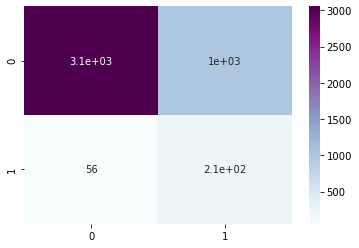

In [105]:
import seaborn as sn
y_train_pred_lg = best_lg.predict(X_train)
mat_lg = confusion_matrix( y_train , y_train_pred_lg )
_ = sn.heatmap(mat_lg, annot=True, cmap = 'BuPu')

In [106]:
print(classification_report(y_train, y_train_pred_lg))

              precision    recall  f1-score   support

           0       0.98      0.75      0.85      4068
           1       0.17      0.79      0.28       268

    accuracy                           0.75      4336
   macro avg       0.58      0.77      0.57      4336
weighted avg       0.93      0.75      0.82      4336



In [107]:
#Print some evaluate metrics on train set
accuracy_test = accuracy_score(y_train, y_train_pred_lg)
recall_test = recall_score(y_train, y_train_pred_lg, pos_label=1, average="binary")
specificity_test = recall_score(y_train, y_train_pred_lg, pos_label=0, average="binary")
precision_test = precision_score(y_train, y_train_pred_lg, pos_label=1, average="binary")
print("\t{m:s} Accuracy: {a:3.1%}, Recall {r:3.1%}, Specificity {s:3.1%}, Precision {p:3.1%}".format(m='test',
                                                                            a=accuracy_test,
                                                                            r=recall_test,
                                                                            s=specificity_test,
                                                                            p=precision_test
                                                                            )
         )

	test Accuracy: 75.4%, Recall 79.1%, Specificity 75.1%, Precision 17.3%


## Fit and cross validation: SVM Classifier

Can we improve our results by a different model? We will do cross validation and tune hyperparameters on SVM to see the results. 

In [108]:
model_pipeline = Pipeline(steps = [('imputer', imputer), 
                                    ('outlier', outlier),
                                    ('scaler', scaler), 
                                    ('pca',pca),
                                   ('smote',smote), 
                                    ('classify', svm_clf)])
param_grid = {
    'classify__gamma': [0.0001, 0.001],
    'classify__C': [0.1, 1, 10,100,1000 ],
}

grid_cv_model = GridSearchCV(model_pipeline, param_grid , cv= 5, scoring =my_score)
grid_cv_model.fit(X_train, y_train)


print("Best parameter (CV score=%0.3f):" % grid_cv_model.best_score_)
print(grid_cv_model.best_params_)

best_svm = grid_cv_model.best_estimator_

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('imputer',
                                        SimpleImputer(strategy='median')),
                                       ('outlier', DealOutlier()),
                                       ('scaler', StandardScaler()),
                                       ('pca', PCA(n_components=0.95)),
                                       ('smote', SMOTE(random_state=42)),
                                       ('classify', SVC())]),
             param_grid={'classify__C': [0.1, 1, 10, 100, 1000],
                         'classify__gamma': [0.0001, 0.001]},
             scoring=make_scorer(my_custom_score_func))

Best parameter (CV score=0.699):
{'classify__C': 100, 'classify__gamma': 0.0001}


## Error Analysis: SVM Classifier
We selected a model and hyperparameters through GridSearchCV. 

Now let's take a look at how is the model's performance on train set.

### Confusion Matrix and Classification Report: SVM 

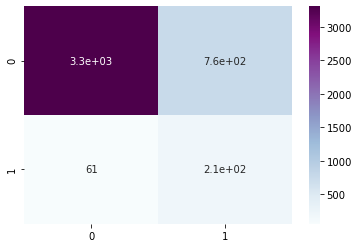

In [109]:
y_train_pred_svm = best_svm.predict(X_train)
mat_svm = confusion_matrix( y_train , y_train_pred_svm )
_ = sn.heatmap(mat_svm, annot=True, cmap = 'BuPu')

In [110]:
print(classification_report(y_train, y_train_pred_svm))

              precision    recall  f1-score   support

           0       0.98      0.81      0.89      4068
           1       0.21      0.77      0.33       268

    accuracy                           0.81      4336
   macro avg       0.60      0.79      0.61      4336
weighted avg       0.93      0.81      0.85      4336



In [111]:
#Print some evaluate metrics on train set
accuracy_test = accuracy_score(y_train, y_train_pred_svm)
recall_test = recall_score(y_train, y_train_pred_svm, pos_label=1, average="binary")
specificity_test = recall_score(y_train, y_train_pred_svm, pos_label=0, average="binary")
precision_test = precision_score(y_train, y_train_pred_svm, pos_label=1, average="binary")
print("\t{m:s} Accuracy: {a:3.1%}, Recall {r:3.1%}, Specificity {s:3.1%}, Precision {p:3.1%}".format(m='test',
                                                                            a=accuracy_test,
                                                                            r=recall_test,
                                                                            s=specificity_test,
                                                                            p=precision_test
                                                                            )
         )

	test Accuracy: 81.0%, Recall 77.2%, Specificity 81.2%, Precision 21.3%


## Fit and cross validation: Decision Tree Classifier

We try another model decision tree. Similarly, we use GridSearchCV to tune hyperparameters and select model

In [44]:
model_pipeline = Pipeline(steps = [('imputer', imputer), 
                                    ('outlier', outlier),
                                    ('scaler', scaler), 
                                    ('pca',pca),
                                   ('smote',smote), 
                                    ('classify', tree_clf)])
param_grid = {
    'classify__max_depth': [2, 3, 4, 5, 10, 15, 20],
    'classify__min_samples_leaf': [1, 2, 3, 5],
}

grid_cv_model = GridSearchCV(model_pipeline, param_grid , cv= 5, scoring =my_score)
grid_cv_model.fit(X_train, y_train)


print("Best parameter (CV score=%0.3f):" % grid_cv_model.best_score_)
print(grid_cv_model.best_params_)

best_tree = grid_cv_model.best_estimator_

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('imputer',
                                        SimpleImputer(strategy='median')),
                                       ('outlier', DealOutlier()),
                                       ('scaler', StandardScaler()),
                                       ('pca', PCA(n_components=0.95)),
                                       ('smote', SMOTE(random_state=42)),
                                       ('classify',
                                        DecisionTreeClassifier(random_state=42))]),
             param_grid={'classify__max_depth': [2, 3, 4, 5, 10, 15, 20],
                         'classify__min_samples_leaf': [1, 2, 3, 5]},
             scoring=make_scorer(my_custom_score_func))

Best parameter (CV score=0.701):
{'classify__max_depth': 3, 'classify__min_samples_leaf': 1}


## Error Analysis: Decision Tree Classifier
We selected a model and hyperparameters through GridSearchCV. 

Now let's take a look at how is the model's performance on train set.

### Confusion Matrix and Classification Report: Decision Tree Classifier

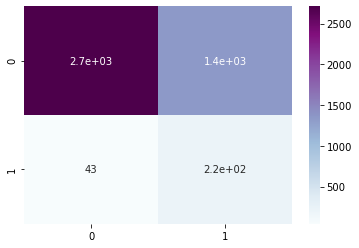

In [45]:
y_train_pred_tree = best_tree.predict(X_train)
mat_tree = confusion_matrix( y_train , y_train_pred_tree )
_ = sn.heatmap(mat_tree, annot=True, cmap = 'BuPu')

In [46]:
print(classification_report(y_train, y_train_pred_tree))

              precision    recall  f1-score   support

           0       0.98      0.67      0.79      4068
           1       0.14      0.84      0.24       268

    accuracy                           0.68      4336
   macro avg       0.56      0.75      0.52      4336
weighted avg       0.93      0.68      0.76      4336



In [47]:
#Print some evaluate metrics on train set
accuracy_test = accuracy_score(y_train, y_train_pred_tree)
recall_test = recall_score(y_train, y_train_pred_tree, pos_label=1, average="binary")
specificity_test = recall_score(y_train, y_train_pred_tree, pos_label=0, average="binary")
precision_test = precision_score(y_train, y_train_pred_tree, pos_label=1, average="binary")
print("\t{m:s} Accuracy: {a:3.1%}, Recall {r:3.1%}, Specificity {s:3.1%}, Precision {p:3.1%}".format(m='test',
                                                                            a=accuracy_test,
                                                                            r=recall_test,
                                                                            s=specificity_test,
                                                                            p=precision_test
                                                                            )
         )

	test Accuracy: 67.7%, Recall 84.0%, Specificity 66.7%, Precision 14.2%


## Fit and cross validation: RandomForest Classifier

Here we try an ensemble model of decision trees.

In [48]:
model_pipeline = Pipeline(steps = [('imputer', imputer), 
                                    ('outlier', outlier),
                                    ('scaler', scaler),
                                   ('pca', pca),
                                   ('smote',smote), 
                                    ('classify', rf_clf)])
param_grid = {
    'classify__max_depth': [2, 3, 4, 5, 10, 15, 20],
    'classify__min_samples_leaf': [1, 2, 3, 5],
    'classify__n_estimators':[10, 20, 30, 50, 100],
}

grid_cv_model = GridSearchCV(model_pipeline, param_grid , cv= 5, scoring =my_score)
grid_cv_model.fit(X_train, y_train)


print("Best parameter (CV score=%0.3f):" % grid_cv_model.best_score_)
print(grid_cv_model.best_params_)

best_rf = grid_cv_model.best_estimator_

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('imputer',
                                        SimpleImputer(strategy='median')),
                                       ('outlier', DealOutlier()),
                                       ('scaler', StandardScaler()),
                                       ('pca', PCA(n_components=0.95)),
                                       ('smote', SMOTE(random_state=42)),
                                       ('classify',
                                        RandomForestClassifier(random_state=42))]),
             param_grid={'classify__max_depth': [2, 3, 4, 5, 10, 15, 20],
                         'classify__min_samples_leaf': [1, 2, 3, 5],
                         'classify__n_estimators': [10, 20, 30, 50, 100]},
             scoring=make_scorer(my_custom_score_func))

Best parameter (CV score=0.698):
{'classify__max_depth': 2, 'classify__min_samples_leaf': 1, 'classify__n_estimators': 20}


## Error Analysis: RandomForest Classifier
We selected a model and hyperparameters through GridSearchCV. 

Now let's take a look at how is the model's performance on train set.

### Confusion Matrix and Classification Report: RandomForest Classifier

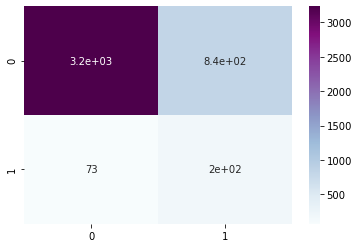

In [49]:
y_train_pred_rf = best_rf.predict(X_train)
map_rf = confusion_matrix( y_train , y_train_pred_rf )
_ = sn.heatmap(map_rf, annot=True, cmap = 'BuPu')

In [50]:
print(classification_report(y_train, y_train_pred_rf))

              precision    recall  f1-score   support

           0       0.98      0.79      0.88      4068
           1       0.19      0.73      0.30       268

    accuracy                           0.79      4336
   macro avg       0.58      0.76      0.59      4336
weighted avg       0.93      0.79      0.84      4336



In [51]:
accuracy_test = accuracy_score(y_train, y_train_pred_rf)
recall_test = recall_score(y_train, y_train_pred_rf, pos_label=1, average="binary")
specificity_test = recall_score(y_train, y_train_pred_rf, pos_label=0, average="binary")
precision_test = precision_score(y_train, y_train_pred_rf, pos_label=1, average="binary")
print("\t{m:s} Accuracy: {a:3.1%}, Recall {r:3.1%}, Specificity {s:3.1%}, Precision {p:3.1%}".format(m='test',
                                                                            a=accuracy_test,
                                                                            r=recall_test,
                                                                            s=specificity_test,
                                                                            p=precision_test
                                                                            )
         )

	test Accuracy: 79.0%, Recall 72.8%, Specificity 79.4%, Precision 18.9%


## Fit and cross validation: Gradient Boosting Tree

Here we try a gradient boosting tree model.

We hope to use boosting to improve results.

In [52]:
model_pipeline = Pipeline(steps = [('imputer', imputer), 
                                    ('outlier', outlier),
                                    ('scaler', scaler), 
                                   ('pca', pca),
                                   ('smote',smote), 
                                    ('classify', gbt_clf)])
param_grid = {
    'classify__max_depth': [2, 3, 4, 5],
    'classify__learning_rate': [ 0.05, 0.1, 0.2],
    'classify__n_estimators':[ 20, 30, 50, 100],
}

grid_cv_model = GridSearchCV(model_pipeline, param_grid , cv= 5, scoring =my_score)
grid_cv_model.fit(X_train, y_train)


print("Best parameter (CV score=%0.3f):" % grid_cv_model.best_score_)
print(grid_cv_model.best_params_)

best_gbt = grid_cv_model.best_estimator_

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('imputer',
                                        SimpleImputer(strategy='median')),
                                       ('outlier', DealOutlier()),
                                       ('scaler', StandardScaler()),
                                       ('pca', PCA(n_components=0.95)),
                                       ('smote', SMOTE(random_state=42)),
                                       ('classify',
                                        GradientBoostingClassifier(random_state=42))]),
             param_grid={'classify__learning_rate': [0.05, 0.1, 0.2],
                         'classify__max_depth': [2, 3, 4, 5],
                         'classify__n_estimators': [20, 30, 50, 100]},
             scoring=make_scorer(my_custom_score_func))

Best parameter (CV score=0.707):
{'classify__learning_rate': 0.05, 'classify__max_depth': 2, 'classify__n_estimators': 50}


## Error Analysis: Gradient Boosting Tree
We selected a model and hyperparameters through GridSearchCV. 

Now let's take a look at how is the model's performance on train set.

### Confusion Matrix and Classification Report: Gradient Boosting Tree

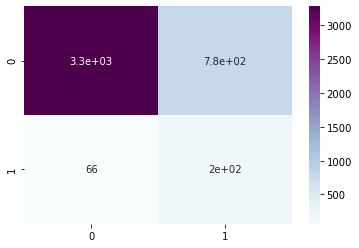

In [53]:
y_train_pred_gbt = best_gbt.predict(X_train)
map_gbt = confusion_matrix( y_train , y_train_pred_gbt )
_ = sn.heatmap(map_gbt, annot=True, cmap = 'BuPu')

In [54]:
print(classification_report(y_train, y_train_pred_gbt))

              precision    recall  f1-score   support

           0       0.98      0.81      0.89      4068
           1       0.20      0.75      0.32       268

    accuracy                           0.80      4336
   macro avg       0.59      0.78      0.60      4336
weighted avg       0.93      0.80      0.85      4336



In [55]:
accuracy_test = accuracy_score(y_train, y_train_pred_gbt)
recall_test = recall_score(y_train, y_train_pred_gbt, pos_label=1, average="binary")
specificity_test = recall_score(y_train, y_train_pred_gbt, pos_label=0, average="binary")
precision_test = precision_score(y_train, y_train_pred_gbt, pos_label=1, average="binary")
print("\t{m:s} Accuracy: {a:3.1%}, Recall {r:3.1%}, Specificity {s:3.1%}, Precision {p:3.1%}".format(m='test',
                                                                            a=accuracy_test,
                                                                            r=recall_test,
                                                                            s=specificity_test,
                                                                            p=precision_test
                                                                            )
         )

	test Accuracy: 80.4%, Recall 75.4%, Specificity 80.7%, Precision 20.5%


## Fit and Cross Validation: XGBoost Classifier (Exploration)
We try to explore a more powerful gradient boosting model: XGBoost Classifier.

XGBoost has some advantages over Gradient Boosting Tree:
- Its computation is faster
- It has regularization to avoid overfitting

The hyperparameters in XGBoost are similar like ones in GBT:
- Hyperparameters about booster: like hyperparameters in trees
- Hyperparameters about learning goal: like learning rate
- Other hyperparameters

In [56]:
from xgboost import XGBClassifier
xgb_clf = XGBClassifier( use_label_encoder=False, random_state= 42, eval_metric='error', booster = 'gbtree')
model_pipeline = Pipeline(steps = [('imputer', imputer), 
                                    ('outlier', outlier),
                                    ('scaler', scaler), 
                                    ('pca',pca),
                                   ('smote',smote), 
                                    ('classify', xgb_clf)])
param_grid = {
    'classify__max_depth': [2, 3, 4, 5],
    'classify__learning_rate': [ 0.05, 0.1, 0.2],
    'classify__n_estimators':[10, 20, 30, 50, 100],
    'classify__gamma':[0.05, 0.1]
}

grid_cv_model = GridSearchCV(model_pipeline, param_grid , cv= 5, scoring =my_score)
grid_cv_model.fit(X_train, y_train)


print("Best parameter (CV score=%0.3f):" % grid_cv_model.best_score_)
print(grid_cv_model.best_params_)

best_xgb = grid_cv_model.best_estimator_

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('imputer',
                                        SimpleImputer(strategy='median')),
                                       ('outlier', DealOutlier()),
                                       ('scaler', StandardScaler()),
                                       ('pca', PCA(n_components=0.95)),
                                       ('smote', SMOTE(random_state=42)),
                                       ('classify',
                                        XGBClassifier(base_score=None,
                                                      booster='gbtree',
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      enable_categorica...
                                                      reg_alpha=None,
 

Best parameter (CV score=0.704):
{'classify__gamma': 0.05, 'classify__learning_rate': 0.05, 'classify__max_depth': 2, 'classify__n_estimators': 10}


## Error Analysis: XGBoost Classifier
We selected a model and hyperparameters through GridSearchCV. 

Now let's take a look at how is the model's performance on train set.

### Confusion Matrix and Classification Report: XGBoost Classifier

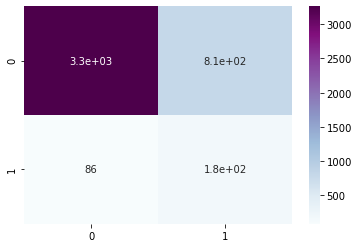

In [57]:
y_train_pred_xgb = best_xgb.predict(X_train)
map_xgb = confusion_matrix( y_train , y_train_pred_xgb )
_ = sn.heatmap(map_xgb, annot=True, cmap = 'BuPu')

In [58]:
print(classification_report(y_train, y_train_pred_xgb))

              precision    recall  f1-score   support

           0       0.97      0.80      0.88      4068
           1       0.18      0.68      0.29       268

    accuracy                           0.79      4336
   macro avg       0.58      0.74      0.58      4336
weighted avg       0.93      0.79      0.84      4336



In [59]:
accuracy_test = accuracy_score(y_train, y_train_pred_xgb)
recall_test = recall_score(y_train, y_train_pred_xgb, pos_label=1, average="binary")
specificity_test = recall_score(y_train, y_train_pred_xgb, pos_label=0, average="binary")
precision_test = precision_score(y_train, y_train_pred_xgb, pos_label=1, average="binary")
print("\t{m:s} Accuracy: {a:3.1%}, Recall {r:3.1%}, Specificity {s:3.1%}, Precision {p:3.1%}".format(m='test',
                                                                            a=accuracy_test,
                                                                            r=recall_test,
                                                                            s=specificity_test,
                                                                            p=precision_test
                                                                            )
         )

	test Accuracy: 79.4%, Recall 67.9%, Specificity 80.2%, Precision 18.4%


## Further Exploration

## Decision Tree, Random Forest, Gradient Boost Tree and XGBoost without PCA
We know that PCA can lower the dimension our features. Logistic Regression may benefit from it.

But we will lose some information as well.

Here we try to remove PCA from our pipeline for tree models and see if the results will improve.(May be time consuming to train)

## DecisionTree without PCA

In [112]:
model_pipeline = Pipeline(steps = [('imputer', imputer), 
                                    ('outlier', outlier),
                                    ('scaler', scaler), 
                                   ('smote',smote), 
                                    ('classify', tree_clf)])
param_grid = {
    'classify__max_depth': [2, 3, 4, 5, 10, 15, 20],
    'classify__min_samples_leaf': [1, 2, 3, 5],
}

grid_cv_model = GridSearchCV(model_pipeline, param_grid , cv= 5, scoring =my_score)
grid_cv_model.fit(X_train, y_train)


print("Best parameter (CV score=%0.3f):" % grid_cv_model.best_score_)
print(grid_cv_model.best_params_)

best_tree_pca = grid_cv_model.best_estimator_

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('imputer',
                                        SimpleImputer(strategy='median')),
                                       ('outlier', DealOutlier()),
                                       ('scaler', StandardScaler()),
                                       ('smote', SMOTE(random_state=42)),
                                       ('classify',
                                        DecisionTreeClassifier(random_state=42))]),
             param_grid={'classify__max_depth': [2, 3, 4, 5, 10, 15, 20],
                         'classify__min_samples_leaf': [1, 2, 3, 5]},
             scoring=make_scorer(my_custom_score_func))

Best parameter (CV score=0.747):
{'classify__max_depth': 3, 'classify__min_samples_leaf': 1}


### Confusion Matrix and Classification Report: Decision Tree Without PCA

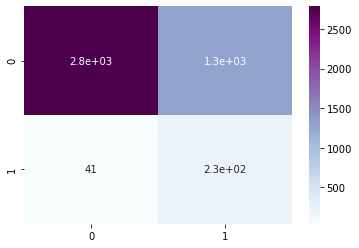

In [113]:
y_train_pred_tree = best_tree_pca.predict(X_train)
mat_tree = confusion_matrix( y_train , y_train_pred_tree )
_ = sn.heatmap(mat_tree, annot=True, cmap = 'BuPu')

In [114]:
print(classification_report(y_train, y_train_pred_tree))

              precision    recall  f1-score   support

           0       0.99      0.68      0.81      4068
           1       0.15      0.85      0.26       268

    accuracy                           0.69      4336
   macro avg       0.57      0.77      0.53      4336
weighted avg       0.93      0.69      0.77      4336



In [115]:
#Print some evaluate metrics on train set
accuracy_test = accuracy_score(y_train, y_train_pred_tree)
recall_test = recall_score(y_train, y_train_pred_tree, pos_label=1, average="binary")
specificity_test = recall_score(y_train, y_train_pred_tree, pos_label=0, average="binary")
precision_test = precision_score(y_train, y_train_pred_tree, pos_label=1, average="binary")
print("\t{m:s} Accuracy: {a:3.1%}, Recall {r:3.1%}, Specificity {s:3.1%}, Precision {p:3.1%}".format(m='test',
                                                                            a=accuracy_test,
                                                                            r=recall_test,
                                                                            s=specificity_test,
                                                                            p=precision_test
                                                                            )
         )

	test Accuracy: 69.4%, Recall 84.7%, Specificity 68.4%, Precision 15.0%


## Random Forest without PCA

In [64]:
model_pipeline = Pipeline(steps = [('imputer', imputer), 
                                    ('outlier', outlier),
                                    ('scaler', scaler),
                                   ('smote',smote), 
                                    ('classify', rf_clf)])
param_grid = {
    'classify__max_depth': [2, 3, 4, 5, 10, 15, 20],
    'classify__min_samples_leaf': [1, 2, 3, 5],
    'classify__n_estimators':[10, 20, 30, 50, 100],
}

grid_cv_model = GridSearchCV(model_pipeline, param_grid , cv= 5, scoring =my_score)
grid_cv_model.fit(X_train, y_train)


print("Best parameter (CV score=%0.3f):" % grid_cv_model.best_score_)
print(grid_cv_model.best_params_)

best_rf_pca = grid_cv_model.best_estimator_

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('imputer',
                                        SimpleImputer(strategy='median')),
                                       ('outlier', DealOutlier()),
                                       ('scaler', StandardScaler()),
                                       ('smote', SMOTE(random_state=42)),
                                       ('classify',
                                        RandomForestClassifier(random_state=42))]),
             param_grid={'classify__max_depth': [2, 3, 4, 5, 10, 15, 20],
                         'classify__min_samples_leaf': [1, 2, 3, 5],
                         'classify__n_estimators': [10, 20, 30, 50, 100]},
             scoring=make_scorer(my_custom_score_func))

Best parameter (CV score=0.707):
{'classify__max_depth': 5, 'classify__min_samples_leaf': 5, 'classify__n_estimators': 20}


### Confusion Matrix and Classification Report: Random Forest Without PCA

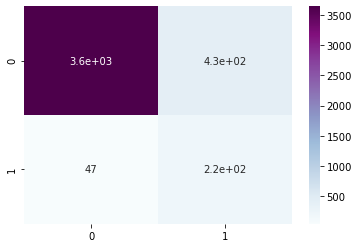

In [65]:
y_train_pred_rf = best_rf_pca.predict(X_train)
mat_rf = confusion_matrix( y_train , y_train_pred_rf )
_ = sn.heatmap(mat_rf, annot=True, cmap = 'BuPu')

In [66]:
print(classification_report(y_train, y_train_pred_rf))

              precision    recall  f1-score   support

           0       0.99      0.89      0.94      4068
           1       0.34      0.82      0.48       268

    accuracy                           0.89      4336
   macro avg       0.66      0.86      0.71      4336
weighted avg       0.95      0.89      0.91      4336



In [67]:
accuracy_test = accuracy_score(y_train, y_train_pred_rf)
recall_test = recall_score(y_train, y_train_pred_rf, pos_label=1, average="binary")
specificity_test = recall_score(y_train, y_train_pred_rf, pos_label=0, average="binary")
precision_test = precision_score(y_train, y_train_pred_rf, pos_label=1, average="binary")
print("\t{m:s} Accuracy: {a:3.1%}, Recall {r:3.1%}, Specificity {s:3.1%}, Precision {p:3.1%}".format(m='test',
                                                                            a=accuracy_test,
                                                                            r=recall_test,
                                                                            s=specificity_test,
                                                                            p=precision_test
                                                                            )
         )

	test Accuracy: 89.0%, Recall 82.5%, Specificity 89.4%, Precision 33.9%


## Gradient Boost Tree without PCA

In [68]:
model_pipeline = Pipeline(steps = [('imputer', imputer), 
                                    ('outlier', outlier),
                                    ('scaler', scaler), 
                                   ('smote',smote), 
                                    ('classify', gbt_clf)])
param_grid = {
    'classify__max_depth': [2, 3, 4, 5],
    'classify__learning_rate': [ 0.05, 0.1, 0.2],
    'classify__n_estimators':[ 20, 30, 50, 100],
}

grid_cv_model = GridSearchCV(model_pipeline, param_grid , cv= 5, scoring =my_score)
grid_cv_model.fit(X_train, y_train)


print("Best parameter (CV score=%0.3f):" % grid_cv_model.best_score_)
print(grid_cv_model.best_params_)

best_gbt_pca = grid_cv_model.best_estimator_

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('imputer',
                                        SimpleImputer(strategy='median')),
                                       ('outlier', DealOutlier()),
                                       ('scaler', StandardScaler()),
                                       ('smote', SMOTE(random_state=42)),
                                       ('classify',
                                        GradientBoostingClassifier(random_state=42))]),
             param_grid={'classify__learning_rate': [0.05, 0.1, 0.2],
                         'classify__max_depth': [2, 3, 4, 5],
                         'classify__n_estimators': [20, 30, 50, 100]},
             scoring=make_scorer(my_custom_score_func))

Best parameter (CV score=0.757):
{'classify__learning_rate': 0.2, 'classify__max_depth': 2, 'classify__n_estimators': 20}


### Confusion Matrix and Classification Report: Gradient Boost Tree Without PCA

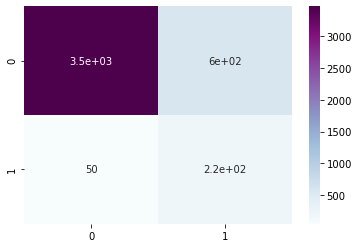

In [69]:
y_train_pred_gbt = best_gbt_pca.predict(X_train)
mat_gbt = confusion_matrix( y_train , y_train_pred_gbt )
_ = sn.heatmap(mat_gbt, annot=True, cmap = 'BuPu')

In [70]:
print(classification_report(y_train, y_train_pred_gbt))

              precision    recall  f1-score   support

           0       0.99      0.85      0.91      4068
           1       0.27      0.81      0.40       268

    accuracy                           0.85      4336
   macro avg       0.63      0.83      0.66      4336
weighted avg       0.94      0.85      0.88      4336



In [71]:
accuracy_test = accuracy_score(y_train, y_train_pred_gbt)
recall_test = recall_score(y_train, y_train_pred_gbt, pos_label=1, average="binary")
specificity_test = recall_score(y_train, y_train_pred_gbt, pos_label=0, average="binary")
precision_test = precision_score(y_train, y_train_pred_gbt, pos_label=1, average="binary")
print("\t{m:s} Accuracy: {a:3.1%}, Recall {r:3.1%}, Specificity {s:3.1%}, Precision {p:3.1%}".format(m='test',
                                                                            a=accuracy_test,
                                                                            r=recall_test,
                                                                            s=specificity_test,
                                                                            p=precision_test
                                                                            )
         )

	test Accuracy: 85.1%, Recall 81.3%, Specificity 85.3%, Precision 26.7%


## XGBoost without PCA

In [72]:
xgb_clf = XGBClassifier( use_label_encoder=False, random_state= 42, eval_metric='error', booster = 'gbtree')
model_pipeline = Pipeline(steps = [('imputer', imputer), 
                                    ('outlier', outlier),
                                    ('scaler', scaler), 
                                   ('smote',smote), 
                                    ('classify', xgb_clf)])
param_grid = {
    'classify__max_depth': [2, 3, 4, 5],
    'classify__learning_rate': [ 0.05, 0.1, 0.2],
    'classify__n_estimators':[10, 20, 30, 50, 100],
    'classify__gamma':[0, 0.05, 0.1]
}

grid_cv_model = GridSearchCV(model_pipeline, param_grid , cv= 5, scoring =my_score)
grid_cv_model.fit(X_train, y_train)


print("Best parameter (CV score=%0.3f):" % grid_cv_model.best_score_)
print(grid_cv_model.best_params_)

best_xgb_pca = grid_cv_model.best_estimator_

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('imputer',
                                        SimpleImputer(strategy='median')),
                                       ('outlier', DealOutlier()),
                                       ('scaler', StandardScaler()),
                                       ('smote', SMOTE(random_state=42)),
                                       ('classify',
                                        XGBClassifier(base_score=None,
                                                      booster='gbtree',
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      enable_categorical=False,
                                                      eval_metric='error',
                                                      gam...
  

Best parameter (CV score=0.755):
{'classify__gamma': 0, 'classify__learning_rate': 0.1, 'classify__max_depth': 2, 'classify__n_estimators': 50}


### Confusion Matrix and Classification Report: XGBoost Without PCA

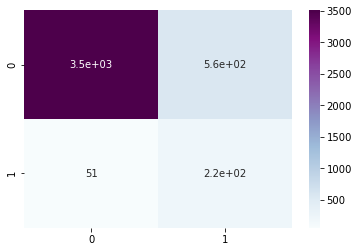

In [73]:
y_train_pred_xgb = best_xgb_pca.predict(X_train)
mat_xgb = confusion_matrix( y_train , y_train_pred_xgb )
_ = sn.heatmap(mat_xgb, annot=True, cmap = 'BuPu')

In [74]:
print(classification_report(y_train, y_train_pred_xgb))

              precision    recall  f1-score   support

           0       0.99      0.86      0.92      4068
           1       0.28      0.81      0.41       268

    accuracy                           0.86      4336
   macro avg       0.63      0.84      0.67      4336
weighted avg       0.94      0.86      0.89      4336



In [75]:
accuracy_test = accuracy_score(y_train, y_train_pred_xgb)
recall_test = recall_score(y_train, y_train_pred_xgb, pos_label=1, average="binary")
specificity_test = recall_score(y_train, y_train_pred_xgb, pos_label=0, average="binary")
precision_test = precision_score(y_train, y_train_pred_xgb, pos_label=1, average="binary")
print("\t{m:s} Accuracy: {a:3.1%}, Recall {r:3.1%}, Specificity {s:3.1%}, Precision {p:3.1%}".format(m='test',
                                                                            a=accuracy_test,
                                                                            r=recall_test,
                                                                            s=specificity_test,
                                                                            p=precision_test
                                                                            )
         )

	test Accuracy: 85.8%, Recall 81.0%, Specificity 86.1%, Precision 27.8%


We found that their performances improved without using PCA to reduce dimensions.

They have higher gridsearchCV scores without PCA.

But it did take longer to train the model.

## Prediction on train set and model selection

So far, we have trained a lot of models. Some of them have higher GridSearchCV scores.

We try to use them to do some predictions on our test set.

We will consider both their scores and performance on test set to decide which one we will use as our final model.

In [107]:
models_set = {'best_lg': best_lg, 
             'best_svm': best_svm,
             'best_tree': best_tree, 
             'best_rf': best_rf,
             'best_gbt': best_gbt,
             'best_xgb': best_xgb,
             'best_tree_pca': best_tree_pca,
             'best_rf_pca': best_rf_pca,
             'best_gbt_pca': best_gbt_pca,
             'best_xgb_pca': best_xgb_pca}
for name, clf in models_set.items():
    y_test_pred = clf.predict(X_test)
    accuracy_test = accuracy_score(y_test, y_test_pred)
    recall_test = recall_score(y_test, y_test_pred, pos_label=1, average="binary")
    specificity_test = recall_score(y_test, y_test_pred, pos_label = 0, average='binary')
    precision_test = precision_score(y_test,   y_test_pred, pos_label=1, average="binary")
    print("\t{m:s} Accuracy: {a:3.1%}, Recall {r:3.1%}, Specificity {s:3.1%}, Precision {p:3.1%}".format(m=name,
                                                                            a=accuracy_test,
                                                                            r=recall_test,
                                                                            s=specificity_test,
                                                                            p=precision_test
                                                                            ) )

	best_lg Accuracy: 72.4%, Recall 80.0%, Specificity 71.7%, Precision 20.4%
	best_svm Accuracy: 77.8%, Recall 75.0%, Specificity 78.1%, Precision 23.6%
	best_tree Accuracy: 66.2%, Recall 80.0%, Specificity 64.9%, Precision 17.1%
	best_rf Accuracy: 79.3%, Recall 75.0%, Specificity 79.6%, Precision 25.0%
	best_gbt Accuracy: 78.0%, Recall 72.5%, Specificity 78.5%, Precision 23.4%
	best_xgb Accuracy: 78.8%, Recall 72.5%, Specificity 79.4%, Precision 24.2%
	best_tree_pca Accuracy: 67.8%, Recall 75.0%, Specificity 67.2%, Precision 17.1%
	best_rf_pca Accuracy: 84.0%, Recall 77.5%, Specificity 84.6%, Precision 31.3%
	best_gbt_pca Accuracy: 82.0%, Recall 75.0%, Specificity 82.6%, Precision 28.0%
	best_xgb_pca Accuracy: 83.4%, Recall 80.0%, Specificity 83.7%, Precision 30.8%


Combined with our in sample, CV scores and out of sample performances, we believe that RandomForest Without PCA would be a better model.

Since it has above average recall and sepcificity and a relatively higher precision.

XGBoost may also be a good model, but it is out of our class content and is more like a try.

## Submission guidelines

Although your notebook may contain many models (e.g., due to your iterative development)
we will only evaluate a single model.
So choose one (explain why !) and do the following.

- You will implement the body of a subroutine `MyModel`
    - That takes as argument a Pandas DataFrame 
        - Each row is an example on which to predict
        - The features of the example are elements of the row
    - Performs predictions on each example
    - Returns an array or predictions with a one-to-one correspondence with the examples in the test set
    

We will evaluate your model against the holdout data
- By reading the holdout examples `X_hold` (as above)
- Calling `y_hold_pred = MyModel(X_hold)` to get the predictions
- Comparing the predicted values `y_hold_pred` against the true labels `y_hold` which are known only to the instructors

See the following cell as an illustration

**Remember**

The holdout data is in the same format as the one we used for training
- Except that it has no attribute for the target
- So you will need to perform all the transformations on the holdout data
    - As you did on the training data
    - Including turning the string representation of numbers into actual numeric data types

All of this work *must* be performed within the body of the `MyModel` routine you will write

We will grade you by comparing the predictions array you create to the answers known to us.

In [116]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import sklearn
import math
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, recall_score, precision_score, precision_recall_curve
from xgboost import XGBClassifier

class DealOutlier(BaseEstimator, TransformerMixin):
    def __init__(self, factor=10):
        self.factor = factor
    
    def fit(self, X, y=None):
        X_ = X.copy()
        X_ = np.array(X_)
        self.upper = []
        self.lower = []
        for i in range(X_.shape[1]):
            col = X_[:,i].copy()
            q1 = np.quantile(col, 0.25)
            q3 = np.quantile(col, 0.75)
            IQR = q3 - q1
            upper = q3 + self.factor*IQR
            lower = q1 - self.factor*IQR
            self.upper.append(upper)
            self.lower.append(lower)
        return self
    
    def transform(self, X, y = None):
        X_ = X.copy()
        X_ = np.array(X_)
        for i in range(X_.shape[1]):
            col = X_[:,i]
            up = self.upper[i]
            lo = self.lower[i]
            col[col > up] = up
            col[col < lo] = lo
        return X_

def my_custom_score_func(y_true, y_pred):
    mat = confusion_matrix(y_true, y_pred)
    spec = mat[0][0]/(mat[0][1] + mat[0][0])
    recall = mat[1][1]/(mat[1][0] + mat[1][1])
    #We divide the sum by 6 to make it within the range of 0-1
    return (spec + 5*recall)/6

def MyModel(X):
    # It should create an array of predictions; we initialize it to the empty array for convenience
    predictions = []
    
    # YOUR CODE GOES HERE
    # Get traindata
    DATA_DIR = "./Data"
    if not os.path.isdir(DATA_DIR):
        DATA_DIR = "../resource/asnlib/publicdata/bankruptcy/data"
    data_file = "5th_yr.csv"
    data = pd.read_csv( os.path.join(DATA_DIR, "train", data_file)) 
    #Shuffle data
    data = sklearn.utils.shuffle(data, random_state=42)
    #since many attributes are not numeric, so firstly we convert all the attributes into numeric
    data = data.apply(lambda x: pd.to_numeric(x, errors = 'coerce'))
    X_ = data.iloc[:, 0:64]
    y_ = data.iloc[:, -2]
    X_train, _ , y_train, _ = train_test_split(X_, y_, test_size = 0.1, random_state = 42)
    #Build pipeline
    imputer = SimpleImputer(strategy='median')
    outlier = DealOutlier()
    scaler = StandardScaler()
    smote = SMOTE(random_state = 42)
    rf_clf = RandomForestClassifier(random_state = 42, max_depth = 5, min_samples_leaf = 5, n_estimators =20 )
    model_pipeline = Pipeline(steps = [('imputer', imputer), 
                                    ('outlier', outlier),
                                    ('scaler', scaler),
                                   ('smote',smote), 
                                    ('classify', rf_clf)])
    model_pipeline.fit(X_train, y_train)
    X_test = X.iloc[:, 0:64].apply(lambda x: pd.to_numeric(x, errors = 'coerce'))
    predictions = model_pipeline.predict(X_test)
    return predictions



# Check your work: predict and evaluate metrics on *your* test examples

Although only the instructors have the correct labels for the holdout dataset, you may want
to create your own test dataset on which to evaluate your out of sample metrics.

If you choose to do so, you can evaluate your models using the same metrics that the instructors will use.

- Test whether your implementation of `MyModel` works
- See the metrics  your model produces

In [121]:
name = "RandomForest"
y_test_pred = MyModel(X_test)

accuracy_test = accuracy_score(y_test, y_test_pred)
recall_test = recall_score(y_test, y_test_pred, pos_label=1, average="binary")
precision_test = precision_score(y_test,   y_test_pred, pos_label=1, average="binary")

print("\t{m:s} Accuracy: {a:3.1%}, Recall {r:3.1%}, Precision {p:3.1%}".format(m=name,
                                                                            a=accuracy_test,
                                                                            r=recall_test,
                                                                            p=precision_test
                                                                            )
         )

	RandomForest Accuracy: 84.0%, Recall 77.5%, Precision 31.3%
